Source: https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Hotellings_Two-Sample_T2.pdf


Example in this notebook:

* We live in a 2D world with a 2D GPS
* There is a point $y_{p}$ in 2D world that we know up to some covariance $S_{p}$
* Now we get multiple datasets with samples from a 2D GPS and we want to test if these where recorded at point $p$.
* We will number these datsets with letters from A, B and C. Each dataset has 100 points. The sample mean will be called $y_{A}$, $y_{B}$, $y_{C}$ and the sample covariances $S_{A} ... S_{C}$. The samples itself will be an array called $Q_{A}...Q_{C}$





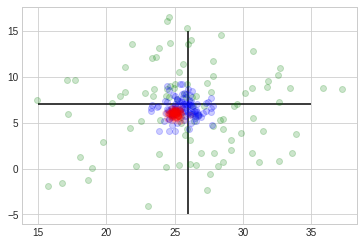

In [9]:
import numpy as np

# define our known location
y_lon_gt = 26
y_lat_gt = 7 
y_p = np.array([y_lon_gt,y_lat_gt])
S_p = np.diag([2,4])
n_p = 1000000000 # very large, as we know the statistics exactly
Q_p = np.random.multivariate_normal(y_p, S_p, 100) # TK: 100 here instead of n_p for visualization?


# create sampling A, B and C
y_A = np.array([25, 6]) # 
S_A = np.diag([0.1, 0.1])
n_A = 100 
Q_A = np.random.multivariate_normal(y_A, S_A, n_A)

y_B = np.array([25.5, 6.5])
S_B = np.diag([20, 20])
n_B = 100
Q_B = np.random.multivariate_normal(y_B, S_B, n_B)

y_C = np.array([25.6, 6.6])
S_C = np.diag([1, 1])
n_C = 100 
Q_C = np.random.multivariate_normal(y_C, S_C, n_C)


# plot that stuff
# TK: "%matplotlib inline" disabled the 'Run-by-line' for me in VS Code :/
#%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
# print(plt.style.available)
plt.style.use('seaborn-whitegrid')

#plt.plot(Q_p[:,0], Q_p[:,1], 'o', color='black', alpha=0.5)
plt.plot(Q_B[:,0], Q_B[:,1], 'o', color='green', alpha=0.2)
plt.plot(Q_C[:,0], Q_C[:,1], 'o', color='blue', alpha=0.2)
plt.plot(Q_A[:,0], Q_A[:,1], 'o', color='red', alpha=0.1)
plt.vlines(y_lon_gt, -5, 15, color='black')
plt.hlines(y_lat_gt, 15, 35, "black")
plt.show()


* Black lines = mean location of P (known up to a covariance)
* Red samples = from distribution A 
* Green samples = from distribution B
* Blue samples = from distribution C

Intuition:
* Red samples: Precisely located at the wrong spot => probably not from our point p
* Green samples: Mean almost at the right position, but large covariance. Some chance that it is observed from point p
* Blue samples: Most likely from our position. But how likely?

Let's test this!

In [10]:
def calc_T2(y_1, S_1, n_1, y_2, S_2, n_2):
    return (y_1 - y_2).T.dot(np.linalg.inv(S_1/n_1 + S_2/n_2)).dot(y_1 - y_2)


def v(S_1, n_1, S_2, n_2):
    Sn1 = S_1/n_1
    Sn2 = S_2/n_2
    
    A = ((Sn1+Sn2).dot(Sn1+Sn2)).trace()
    B =  (Sn1+Sn2).trace()**2
    C = ((Sn1.dot(Sn1)).trace() + Sn1.trace() **2)/(n_1-1)
    D = ((Sn2.dot(Sn2)).trace() + Sn2.trace() **2)/(n_2-1)
    
    return (A+B)/(C+D)


Our null hypothesis for each distribution $A$, $B$, $C$ is, that the distribution is equal to our point $p$.
We reject null hypothesis for $T2 \geq v$.


In [11]:
# For Distribution A:
t2_A = calc_T2(y_p, S_p, n_p, y_A, S_A, n_A)
v_A = v(S_p, n_p, S_A, n_A)

print(t2_A)
print(v_A)
print(t2_A >= v_A)


1999.9940000199997
99.00059400092401
True


In [12]:
t2_B = calc_T2(y_p, S_p, n_p, y_B, S_B, n_B)
v_B = v(S_p, n_p, S_B, n_B)

print(t2_B)
print(v_B)
print(t2_B >= v_B)


2.4999999625000004
99.00000297000001
False


In [13]:
t2_C = calc_T2(y_p, S_p, n_p, y_C, S_C, n_C)
v_C = v(S_p, n_p, S_C, n_C)

print(t2_C)
print(v_C)
print(t2_C >= v_C)



31.999990400003114
99.00005940000925
False


Conclusion, what does this tell us?

* It is unlikely that distribution A (red) was sampled at point $p$
* It is possible that distribution B (green) was sampled at point $p$
* It is also possible that distribution C (blue) was sampled at point $p$

If we had to select one, which one would you choose?

* Probably the one that is able to explain the data with the smallest covariance?, so in this case this would probably be C
* Could e.g. create a score that relates how close we are to reject the hypothesis with the trace of the covariance matrix, $trace(S)*t2/v$

This would yield the following for distribution B and C (lower = better)


In [14]:
print("B:")
print(S_B.trace()*(t2_B/v_B))

print("C:")
print(S_C.trace()*(t2_C/v_C))


B:
1.010100964646466
C:
0.6464640646468163


Nice work! And sweet suggestion for the score.

Some remarks/questions:
 * Why is there no p-value? (p-value: "significance level", typically 5% or 1%)
 * In the score: Why $trace(S)$ (and not e.g. $det(S)$)? What about offdiagonal entries? (or would that be against iid?)
 * The values of $v_i$ are all in the same ballpark (isn't that somewhat counter intuitive? Or is that due to the large value of $n_p$?)
 * ...

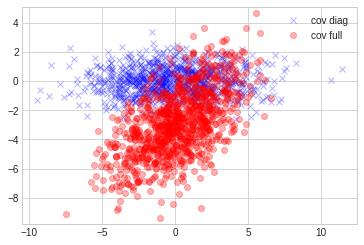

In [15]:
# dummy sample
mean1 = [0, 0]
cov1 = [[10, 0], [0, 1]]
x1, y1 = np.random.multivariate_normal(mean1, cov1, 1000).T

mean2 = [0, -3]
cov2 = np.diag([3, 3])
cov2 = [[3, 5], [5, 3]]
x2, y2 = np.random.multivariate_normal(mean2, cov2, 1000).T

plt.plot(x1, y1, 'x', color='b', alpha=0.3, label='cov diag')
plt.plot(x2, y2, 'o', color='r', alpha=0.3, label='cov full')

plt.axis('equal')
plt.legend(loc="upper right")
plt.show()